# Classificação de Estágios da Doença de Alzheimer

## Convolutional Neural Network - ResNet

Redes neurais convolucionais (CNN, do inglês Convolutional Neural Network) são um tipo de rede neural do tipo feed-foward regularizada que consegue aprender features via filtros específicos (convoluções).

ResNet (Residual Network) é uma arquitetura de rede neural profunda desenvolvida para resolver o problema da degradação em redes muito profundas, onde o aumento do número de camadas pode piorar o desempenho. Ela introduz blocos residuais, que permitem que o sinal de entrada seja "pulada" através de uma conexão direta para a camada seguinte, facilitando o treinamento de redes com muitas camadas.

In [164]:
import os
import random
import numpy as np
import pandas as pd

In [165]:
from sklearn.calibration import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    hamming_loss,
    jaccard_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

In [167]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

### Variáveis iniciais

In [168]:
# Valor fixo de seed para reprodutibilidade
random_seed = 42

# Pasta do dataset
dataset_folder = "../data/Alzheimer_MRI_4_classes_dataset" # Dataset original https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset?select=Alzheimer_MRI_4_classes_dataset
# dataset_folder = "../data/Alzheimer_s_dataset/AugmentedAlzheimerDataset" # Dataset aumentado https://data.mendeley.com/datasets/ch87yswbz4/1
folders = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

# Número máximo de imagens a serem carregadas em cada classe
max_images_per_class = 400

In [169]:
num_epochs = 50
batch_size = 32
learning_rate = 0.001

### Random Seed

In [170]:
# Função para fixar a seed e garantir reprodutibilidade
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para GPUs múltiplas
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Chamar a função com o seed desejado
set_seed(random_seed)

### Carregar dados

In [171]:
# Dicionário para mapear pastas (classes) a inteiros
class_to_int = {folder: idx for idx, folder in enumerate(folders)}
class_to_int

{'NonDemented': 0,
 'VeryMildDemented': 1,
 'MildDemented': 2,
 'ModerateDemented': 3}

In [172]:
# Dataset customizado de imagens
class AlzheimerDataset(Dataset):
    def __init__(
        self, dataset_folder, folders, transform=None, max_images_per_class=100, class_to_idx=None
    ):
        self.dataset_folder = dataset_folder
        self.folders = folders
        self.transform = transform
        self.max_images_per_class = max_images_per_class
        self.class_to_idx = class_to_idx or {folder: idx for idx, folder in enumerate(folders)}

        self.images = []
        self.labels = []

        # Carregar as imagens e os rótulos
        for folder in folders:
            folder_path = os.path.join(dataset_folder, folder)
            if os.path.exists(folder_path):
                count = 0
                for img_name in os.listdir(folder_path):
                    if count >= max_images_per_class:
                        break
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        image = Image.open(img_path).convert("RGB")
                        label = self.class_to_idx[folder]  # Converter para índice
                        if self.transform:
                            image = self.transform(image)
                        self.images.append(image)
                        self.labels.append(label)
                        count += 1
                    except Exception as e:
                        print(f"Erro ao processar a imagem {img_name}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Retorna a imagem e o rótulo como tensores
        return self.images[idx], torch.tensor(self.labels[idx])

# Transformação de pré-processamento
transform = transforms.Compose(
    [
        # transforms.Resize((176, 128)),  # Redimensionar para 176x128
        transforms.Resize((224, 224)),  # Redimensionar para 224x224
        transforms.ToTensor(),  # Converte a imagem para tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalização com valores padrão para ResNet
        # transforms.Normalize((0.5,), (0.5,)),  # Normalização
    ]
)

# Criar o dataset
train_dataset = AlzheimerDataset(
    dataset_folder=dataset_folder,
    folders=folders,
    transform=transform,
    max_images_per_class=max_images_per_class,
    class_to_idx=class_to_int,
)

### Rótulos

In [173]:
# Codificar os rótulos
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

### Dividir em treino e teste

In [174]:
# Proporção do conjunto de validação
val_split_ratio = 0.2

# Cálculo dos tamanhos dos conjuntos
total_size = len(train_dataset)
val_size = int(total_size * val_split_ratio)
train_size = total_size - val_size

# Divide o dataset em treinamento e validação
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Cria os DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)  # shuffle=False para validação

### Treinar o modelo

In [175]:
print("Versão do PyTorch: ", torch.__version__) # Mostra a versão do PyTorch
print("CUDA disponível: ", torch.cuda.is_available()) # Confirma se o CUDA está disponível
print("Versão do CUDA: ", torch.version.cuda) # Mostra a versão do CUDA compatível com o PyTorch

# Utilizar GPU se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Versão do PyTorch:  2.3.1+cu121
CUDA disponível:  True
Versão do CUDA:  12.1
Device: cuda


In [176]:
# Carregar o ResNet50 (modo obsoleto)
# model = models.resnet50(pretrained=True)

# Carregar o ResNet50 (modo atual)
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Congelar as camadas convolucionais (não treinar esses parâmetros)
for param in model.parameters():
    param.requires_grad = False

# Deixe a última camada totalmente conectada (fc) ser treinada
for param in model.fc.parameters():
    param.requires_grad = True

# Ajustar a última camada para o número de classes
model.fc = torch.nn.Linear(model.fc.in_features, len(folders))

In [177]:
# Definir a função de perda
criterion = nn.CrossEntropyLoss()  # Usado para problemas de classificação multiclasse

# Definir a função de perda para lidar com classes desbalanceadas
# class_weights = [1.0, 1.0, 1.0, 1.0]  # Pesos iniciais para as classes
# weights = torch.tensor(class_weights).float().to(device) # Calcular os pesos automaticamente, ou definir valores próprios
# criterion = nn.CrossEntropyLoss(weight=weights) # Usado para problemas de classificação multiclasse

# Definir o otimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Otimizador Adam

In [178]:
# Mover para o dispositivo de treino
model.to(device)

model.train()  # Coloca o modelo no modo de treinamento

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:

        # Mover os dados para o dispositivo (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero os gradientes dos parâmetros do modelo
        optimizer.zero_grad()

        # Passa os dados pelo modelo
        outputs = model(inputs)

        # Calcula a perda
        loss = criterion(outputs, labels)

        # Retropropagação (backpropagation) para atualizar os pesos
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        # Predições
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Acumular a perda para monitoramento
        running_loss += loss.item()

    # Métricas de treinamento
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # # Avaliação no conjunto de validação
    # model.eval()  # Modo de avaliação
    # val_loss = 0.0
    # val_correct = 0
    # val_total = 0

    # # Desativa gradientes para validação
    # with torch.no_grad():
    #     for val_inputs, val_labels in val_loader:
    #         val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
    #         val_outputs = model(val_inputs)
    #         val_loss += criterion(val_outputs, val_labels).item()
    #         _, val_predicted = torch.max(val_outputs, 1)
    #         val_total += val_labels.size(0)
    #         val_correct += (val_predicted == val_labels).sum().item()

    # val_loss /= len(val_loader)
    # val_accuracy = 100 * val_correct / val_total

    # print(
    #     f"Epoch [{epoch+1}/{num_epochs}], "
    #     f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
    #     f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
    # )

    # Exibir informações sobre o progresso
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/50], Loss: 1.2065, Accuracy: 41.01%
Epoch [2/50], Loss: 1.0666, Accuracy: 56.42%
Epoch [3/50], Loss: 0.9820, Accuracy: 59.58%
Epoch [4/50], Loss: 0.9236, Accuracy: 63.04%
Epoch [5/50], Loss: 0.8694, Accuracy: 65.61%
Epoch [6/50], Loss: 0.8305, Accuracy: 68.48%
Epoch [7/50], Loss: 0.8015, Accuracy: 67.29%
Epoch [8/50], Loss: 0.7668, Accuracy: 71.15%
Epoch [9/50], Loss: 0.7382, Accuracy: 71.54%
Epoch [10/50], Loss: 0.7025, Accuracy: 74.31%
Epoch [11/50], Loss: 0.6784, Accuracy: 76.09%
Epoch [12/50], Loss: 0.6720, Accuracy: 75.99%
Epoch [13/50], Loss: 0.6350, Accuracy: 78.95%
Epoch [14/50], Loss: 0.6220, Accuracy: 78.75%
Epoch [15/50], Loss: 0.6029, Accuracy: 80.73%
Epoch [16/50], Loss: 0.5826, Accuracy: 82.91%
Epoch [17/50], Loss: 0.5674, Accuracy: 83.50%
Epoch [18/50], Loss: 0.5564, Accuracy: 83.60%
Epoch [19/50], Loss: 0.5440, Accuracy: 84.98%
Epoch [20/50], Loss: 0.5176, Accuracy: 85.38%
Epoch [21/50], Loss: 0.5216, Accuracy: 86.36%
Epoch [22/50], Loss: 0.4993, Accuracy: 86.4

In [179]:
# Colocar o modelo em modo de avaliação
model.eval()

# Listas para armazenar os resultados
y_true = []
y_pred = []
y_pred_proba = []

# Desativar o cálculo de gradientes para economizar memória
with torch.no_grad():
    # for inputs, labels in test_loader:
    for inputs, labels in val_loader:
        # Mover os dados para o dispositivo (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Passar os dados pelo modelo
        outputs = model(inputs)

        # Probabilidades (softmax para obter valores entre 0 e 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        y_pred_proba.extend(probabilities.cpu().numpy())  # Convertendo para NumPy

        # Predições (classe com maior probabilidade)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Converter listas para arrays NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [180]:
y_test = y_true
# target_names = folders
target_names = [name for name, _ in sorted(class_to_int.items(), key=lambda x: x[1])]

### Métricas

In [181]:
# Acurácia

print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.746031746031746


In [182]:
# Relatório de classificação

print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))

Relatório de classificação:
                  precision    recall  f1-score   support

     NonDemented       0.74      0.86      0.79        76
VeryMildDemented       0.66      0.56      0.60        70
    MildDemented       0.78      0.79      0.78        92
ModerateDemented       1.00      0.79      0.88        14

        accuracy                           0.75       252
       macro avg       0.79      0.75      0.77       252
    weighted avg       0.75      0.75      0.74       252



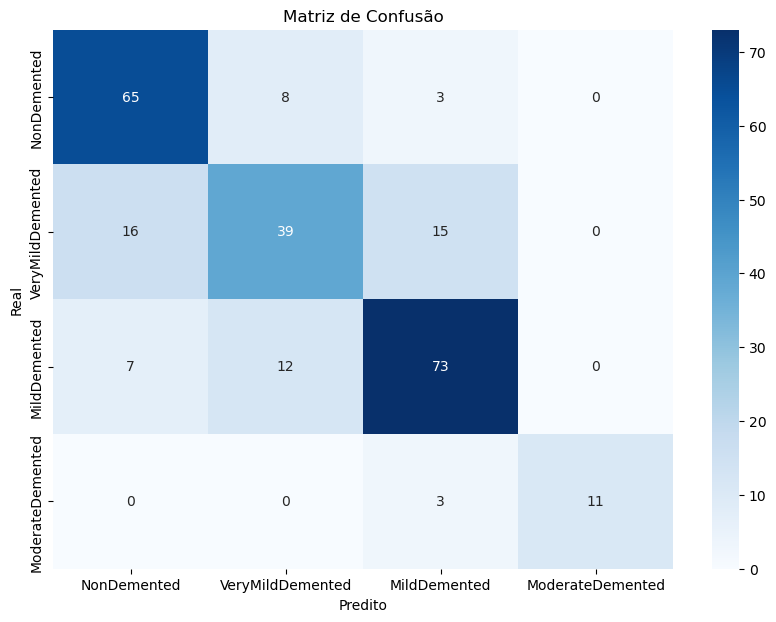

In [183]:
# Matriz de confusão
# É uma ferramenta visual que mostra o desempenho do modelo em cada classe

cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando Seaborn com a paleta Set2
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [184]:
# Área sobre a curva ou AUC para cada classe

y_test_binarized = label_binarize(y_test, classes=np.arange(len(folders)))
auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

AUC: 0.9254006926337128


In [185]:
# Log Loss (Logarithmic Loss)
# Mede a incerteza das previsões. Penaliza previsões incorretas com alta confiança mais severamente do que previsões incorretas com baixa confiança.

log_loss_value = log_loss(y_test, y_pred_proba)
print("Log Loss:", log_loss_value)

Log Loss: 0.6123335582601573


c:\ProgramData\Miniconda3\envs\scipy\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [186]:
# Cohen's Kappa
# Mede a concordância entre as previsões do modelo e os rótulos verdadeiros, ajustando para a concordância que ocorre por acaso.

kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.6324856439704676


In [187]:
# Hamming Loss
# Mede a fração de rótulos incorretamente previstos. É útil para problemas multilabel.

hamming = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hamming)

Hamming Loss: 0.25396825396825395


In [188]:
# Jaccard Index
# Mede a similaridade entre os conjuntos de rótulos previstos e os rótulos verdadeiros.

jaccard = jaccard_score(y_test, y_pred, average='macro')
print("Jaccard Index:", jaccard)

Jaccard Index: 0.63040774368208


In [189]:
# Matthews Correlation Coefficient (MCC)
# Considera todos os elementos da matriz de confusão e é uma métrica equilibrada que pode ser usada mesmo se as classes tiverem tamanhos muito diferentes.

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.6345250364773867
